In [ ]:
#TODO insert only needed package

import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision.transforms import Compose, ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch import nn

from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files
from fastai.data.core import DataLoaders
import PIL

import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from IPython import display

import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

#LOSS
!pip install torchmetrics
!pip install lpips

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 12.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 7.3 MB/s eta 0:00:00


###DATASET CREATION

In [ ]:
path = untar_data(URLs.COCO_SAMPLE) 
coco_path = str(path) + "/train_sample" 

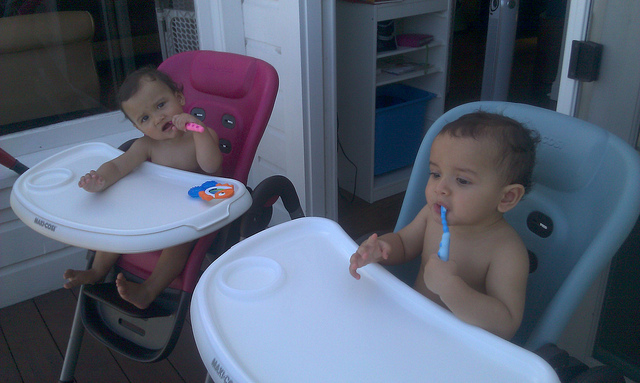

In [ ]:
dataset = get_image_files(coco_path)   
img = PIL.Image.open(dataset[1])
img

In [ ]:
print("INFO DATASET:")
print("Lunghezza: ", len(dataset))
print("Dimensioni immagini: ", img.size)

INFO DATASET:
Lunghezza:  21837
Dimensioni immagini:  (640, 383)


In [ ]:
'''
@param fname image file name in the dataset
@param size size for the final image after resizing
@return Tensor representation of the image
'''
def open_resize_image(fname, size=256): 
    img = PIL.Image.open(fname)
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

In [ ]:
open_resize_image(dataset[0]).shape

torch.Size([3, 256, 256])

In [ ]:
paths = glob.glob(coco_path+"/*.jpg")                                # paths is a list with all image files names of the COCO dataset
np.random.seed(123)                                                  # Seeding for reproducible results
paths_subset = np.random.choice(paths, 10000, replace=False)         # Randomly choosing 10,000 images (image file names) from the list
rand_idxs = np.random.permutation(10000)                             # Shuffling the indexes
train_idxs = rand_idxs[:8000]                                        # Using first 8000 images for training
test_idxs = rand_idxs[8000:]                                         # Using last 2000 images for testing
train_paths = paths_subset[train_idxs]                               # Array with all the image files names for the training
test_paths = paths_subset[test_idxs]                                   # Array with all the image files names for the validation
print(len(train_paths), len(test_paths))

8000 2000


In [ ]:
SIZE= 256
class CustomDataset(Dataset):

    def __init__(self, paths, transform, training_mode=True):
        self.paths = paths
        self.size = SIZE
        self.training_mode = training_mode

        if training_mode:
          self.transform = transform
        else:
          #simple resize to the SIZE x SIZE dimensions
          self.transform = Compose([
              transforms.Resize((SIZE,SIZE), Image.BICUBIC),
          ])

    def __getitem__(self, index):
        #open the image as an RGB image and apply the correct transformations and transform to numpy array
        img = Image.open(self.paths[index]).convert("RGB")
        img = self.transform(img)
        img = np.array(img)

        #converting RGB to L*a*b color space used for the task and then to a tensor
        img_lab = rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
        
    def __len__(self): 
      return len(self.paths)
 


In [ ]:
#define the train, validation and test dataset and the batch size
batch_size = 16

train_transform = transforms.Compose([
     transforms.Resize((SIZE,SIZE), Image.BICUBIC),
])

train_dataset =  CustomDataset(train_paths, train_transform, training_mode = True)
test_dataset =  CustomDataset(test_paths, transform = None, training_mode = False)
#test_dataset =  ImageDataset("./", "test", ToTensor())

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
data = next(iter(train_dataloader))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dataloader), len(test_dataloader))
type(data['L'])

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


torch.Tensor

###UNET AND PATCH DISCRIMINATOR MODELS DEFINITION

In [ ]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 2, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs


In [ ]:
import torch
import torch.nn as nn

class ConvBNLeakyRelu(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size=(4,4), stride=(2,2), padding=(1,1)):
    super().__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding, bias=False)
    self.bn1 = nn.BatchNorm2d(out_ch, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

  def forward(self,inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)
    return x

class ConvLeakyRelu(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=(4,4), stride=(2,2), padding=(1,1))
    self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

  def forward(self,inputs):
    x = self.conv1(inputs)
    x = self.relu(x)
    return x

class PatchDiscriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        ConvLeakyRelu(3,64),
        ConvBNLeakyRelu(64,128),
        ConvBNLeakyRelu(128,256),
        ConvBNLeakyRelu(256,512, stride=(1,1)),
        nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    )

  def forward(self, inputs):
    return self.model(inputs)

In [ ]:
#param: model that has to be initialized
#param: init, how to initialize the weights (xavier or norm)
def initialize_weights(model, init="normal"):
    classname = model.__class__.__name__
    if classname.find('Conv2d') != -1:
        if(init=="xavier"): 
          nn.init.xavier_uniform_(model.weight.data)
        if(init=="normal"):
          nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.2)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
d = PatchDiscriminator()
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = d(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

###TRAINING TEST


In [ ]:
""" GANLoss: 
Class that computes the loss for generator and discriminator
Keyword arguments:
    loss -- loss function we want to use
"""
class GANLoss(nn.Module):
  
    def __init__(self, loss):
        super().__init__()
        self.loss = loss
    
    def get_filled_tensor(self, preds, is_target_real):
        if is_target_real:
            target = torch.ones_like(preds)
        else:
            target = torch.zeros_like(preds)
        return target
    
    def __call__(self, preds, is_target_real):
        labels =self.get_filled_tensor(preds, is_target_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
""" ImprovedGANLoss
Class that computes the loss for generator and discriminator; the loss function
is a perceptual one; it is used only for the generator, instead the discriminator 
still uses the cross entropy
"""
class ImprovedGANLoss(nn.Module):
  def __init__(self, backbone_network):
     super().__init__()
     self.loss = LearnedPerceptualImagePatchSimilarity(net_type=backbone_network)

  def normalize_tensor_values(self, input_tensor):
    flattened_output = input_tensor.view(input_tensor.shape[0], -1, 1, 1)
    min, _ = torch.min(flattened_output, dim=1, keepdim=True)
    max, _ = torch.max(flattened_output, dim=1, keepdim=True)
    input_tensor = (input_tensor - min) / (max - min)
    return input_tensor

  def __call__(self, real_preds, fake_preds):
    real_image = self.normalize_tensor_values(real_preds)
    fake_image = self.normalize_tensor_values(fake_preds)
    return self.loss(real_image, fake_image)


In [ ]:
class MainModel(nn.Module):

    def __init__(self, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        #setting the device to cuda or cpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        #create the Unet and move it to the device
        self.generator = Unet()
        self.generator.apply(initialize_weights)
        self.generator.to(self.device)

        #create the PatchDiscriminator and move it to the device
        self.discriminator = PatchDiscriminator()
        self.discriminator.apply(initialize_weights)
        self.discriminator.to(self.device)

        #define the losses
        self.GANcriterion = GANLoss(loss = nn.BCEWithLogitsLoss()).to(self.device)
        self.ImprovedGANCriterion = ImprovedGANLoss('vgg').to(self.device)
        self.L1criterion = nn.L1Loss()

        #setting up the optimizer for discriminator and generator training
        self.generator_optimizer = optim.Adam(self.generator.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr_D, betas=(beta1, beta2))
        
    def setup_input(self, data):
        #setting data for training: divide the L and ab channels and move it to the device
        self.L = data['L'].to("cuda")
        self.ab = data['ab'].to("cuda")
        
    def forward(self):
        self.fake_color = self.generator(self.L)
    
    def backward_D(self):
        #create a batch of fake colored images and obtain the discriminator predictions
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.discriminator(fake_image.detach())

        #compute the discriminator loss for labeling fake samples as true
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        
        #retrieve a batch of real colored images and obtain the discriminator predictions
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.discriminator(real_image)

        #compute the discriminator loss for labeling true samples as fake
        self.loss_D_real = self.GANcriterion(real_preds, True)

        #compute a simple mean of the two losses and use is for the training of the discriminator
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G_improved(self):
      #generate a fake image and obtain the discriminator labels
      fake_image = torch.cat([self.L, self.fake_color], dim=1)
      fake_preds = self.discriminator(fake_image)

      #generate an Lab image with L level at a constat value
      base_image = torch.full((16,1,256,256),0).cuda()

      #generate the fake image and compute discriminator labels
      fake_image_based = torch.cat([base_image, self.fake_color], dim=1)

      #get real_image, helpful for the perceptual loss function
      real_image_based = torch.cat([base_image, self.ab], dim=1)

      #compute the generator loss with the perceptual losses
      self.loss_G_GAN_PERC = self.ImprovedGANCriterion(real_image_based, fake_image_based)
      self.loss_G_GAN_CRIT = self.GANcriterion(fake_preds, True)
      self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
      self.loss_G = self.loss_G_GAN_PERC + self.loss_G_L1 + self.loss_G_GAN_CRIT
      self.loss_G.backward()
    
    ''' RIKY 
    def backward_G_improved(self):
      #generate the fake image and compute discriminator labels
      fake_image = torch.cat([self.L, self.fake_color], dim=1)
      fake_preds = self.discriminator(fake_image)

      #get real_image, helpful for the perceptual loss function
      real_image = torch.cat([self.L, self.ab], dim=1)

      #compute the generator loss with the perceptual losses
      self.loss_G_GAN = self.ImprovedGANCriterion(real_image, fake_image)
      self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
      self.loss_G = self.loss_G_GAN + self.loss_G_L1
      self.loss_G.backward() '''
    
    def optimize(self):
        #generate a fake colored image with the generator and train it
        self.forward()
        self.discriminator.train()
        for p in self.discriminator.parameters():
            p.requires_grad = True 
        self.discriminator_optimizer.zero_grad()
        self.backward_D()
        self.discriminator_optimizer.step()
        
        self.generator.train()
        for p in self.discriminator.parameters():
            p.requires_grad = False 
        self.generator_optimizer.zero_grad()
        self.backward_G_improved() # modificare qua per perceptual
        self.generator_optimizer.step()

    #param: path_g where to save the generator parameters
    #param: path_d where to save the discriminator parameters
    #param: path_go where to save the generator optimizer parameters
    #param: path_do where to save the discriminator optimizer parameters
    def save_model_and_optimizers_state(self, path_g, path_d, path_go, path_do):
        torch.save(self.generator.state_dict(), path_g)
        torch.save(self.discriminator.state_dict(), path_d)
        torch.save(self.discriminator_optimizer.state_dict(), path_do)
        torch.save(self.generator_optimizer.state_dict(), path_go)

    #param: path_g from where to load the generator parameters
    #param: path_d from where to load the discriminator parameters
    #param: path_go from where to load the generator optimizer parameters
    #param: path_do from where to load the discriminator optimizer parameters
    def load_model_and_optimizers_state(self, path_g, path_d, path_go, path_do):
        self.generator.load_state_dict(torch.load(path_g))
        self.discriminator.load_state_dict(torch.load(path_d))
        self.discriminator_optimizer.load_state_dict(torch.load(path_do))
        self.generator_optimizer.load_state_dict(torch.load(path_go))

#### Utilities functions 

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN_PERC = AverageMeter()
    loss_G_GAN_CRIT = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN_PERC': loss_G_GAN_PERC,
            'loss_G_GAN_CRIT': loss_G_GAN_CRIT, 
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.generator.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.generator.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

#### Training function

In [ ]:
#param: model that must be trained
#param: train_dl train dataloader 
#param: epochs number of training epochs
#param: path_g where to save the generator parameters
#param: path_d where to save the discriminator parameters
#param: path_go where to save the generator optimizer parameters
#param: path_do where to save the discriminator optimizer parameters
def train_model(model, train_dl, epochs, path_g, path_d, path_go, path_do):
    data = next(iter(test_dataloader))         # getting a batch for visualizing the model output after fixed intervals
    #model.load_model_and_optimizers_state(path_g, path_d, path_go, path_do)
    for e in range(epochs):
        torch.cuda.empty_cache()
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):           
            model.setup_input(data)            # load the batch and separate the L and ab channels   
            model.optimize()                   
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % 200 == 0:                   # every 200 batch visualize the progress in the loss functions and in the images generated
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

        #at the end of the epoch we save the models parameters and the optimizers states
        model.save_model_and_optimizers_state(path_g, path_d, path_go, path_do)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/100
Iteration 200/500
loss_D_fake: 0.50823
loss_D_real: 0.50730
loss_D: 0.50776
loss_G_GAN_PERC: 0.51291
loss_G_GAN_CRIT: 1.39476
loss_G_L1: 10.16184
loss_G: 12.06950


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 37 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


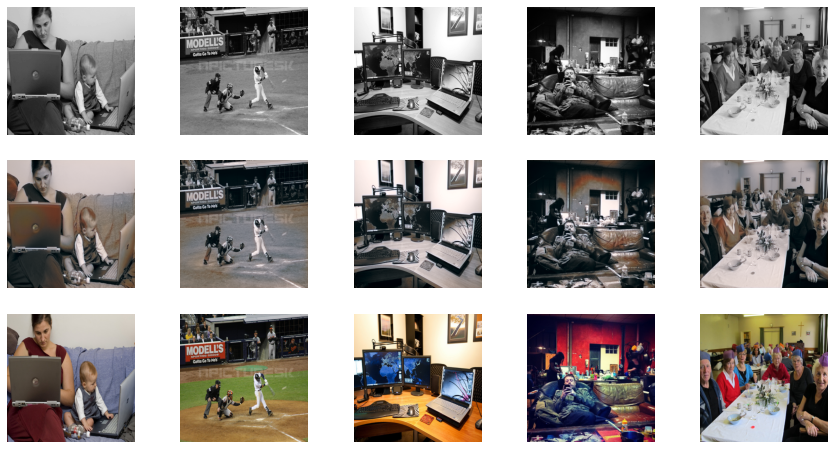


Epoch 1/100
Iteration 400/500
loss_D_fake: 0.48558
loss_D_real: 0.51028
loss_D: 0.49793
loss_G_GAN_PERC: 0.51791
loss_G_GAN_CRIT: 1.45322
loss_G_L1: 10.44115
loss_G: 12.41228


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4096 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 18 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 89 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 14019 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 20 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: 

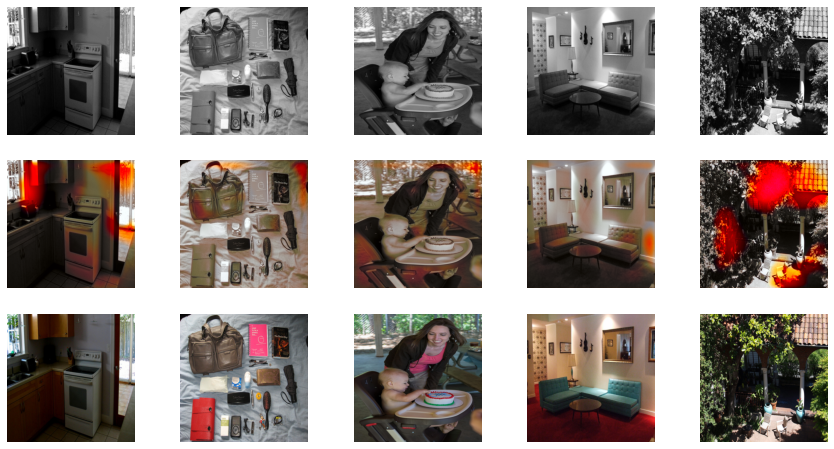

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2/100
Iteration 200/500
loss_D_fake: 0.47460
loss_D_real: 0.54430
loss_D: 0.50945
loss_G_GAN_PERC: 0.53912
loss_G_GAN_CRIT: 1.45555
loss_G_L1: 11.12197
loss_G: 13.11663


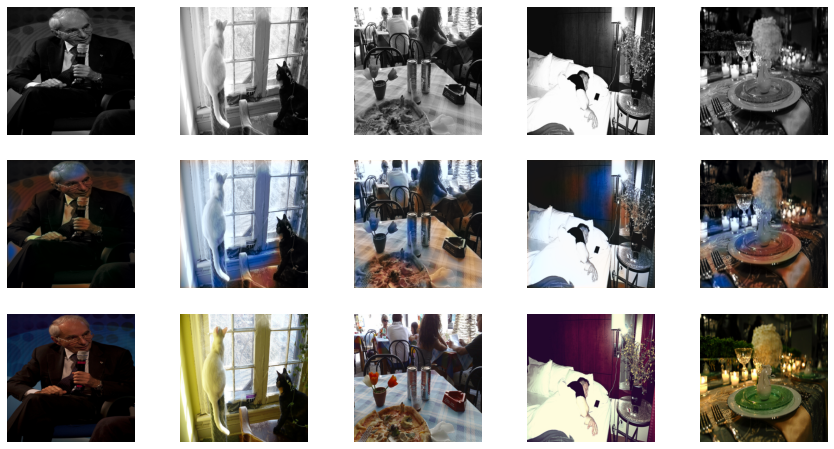


Epoch 2/100
Iteration 400/500
loss_D_fake: 0.48409
loss_D_real: 0.54880
loss_D: 0.51644
loss_G_GAN_PERC: 0.52758
loss_G_GAN_CRIT: 1.40460
loss_G_L1: 11.04919
loss_G: 12.98137


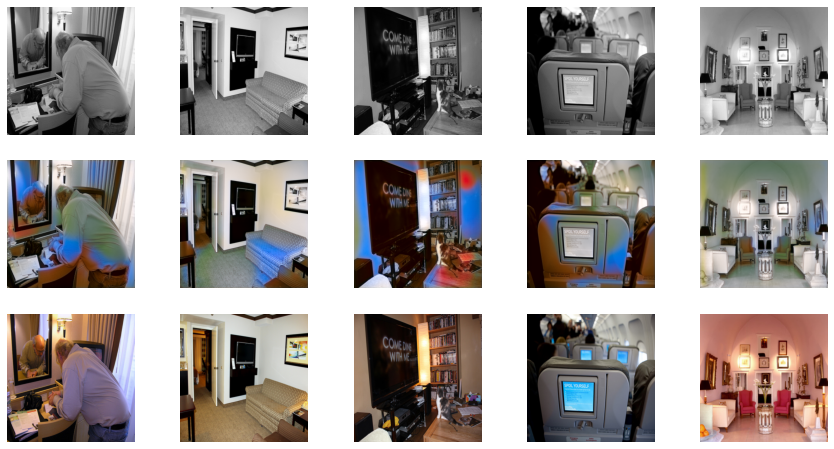

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3/100
Iteration 200/500
loss_D_fake: 0.53772
loss_D_real: 0.60238
loss_D: 0.57005
loss_G_GAN_PERC: 0.50466
loss_G_GAN_CRIT: 1.21625
loss_G_L1: 10.96835
loss_G: 12.68926


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 102 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color d

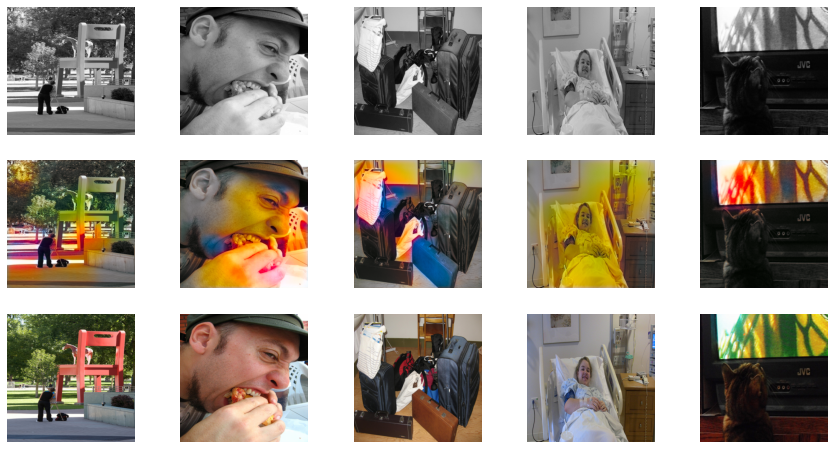


Epoch 3/100
Iteration 400/500
loss_D_fake: 0.53124
loss_D_real: 0.60043
loss_D: 0.56583
loss_G_GAN_PERC: 0.50584
loss_G_GAN_CRIT: 1.25825
loss_G_L1: 11.04770
loss_G: 12.81178


/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 180 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.8/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3702 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


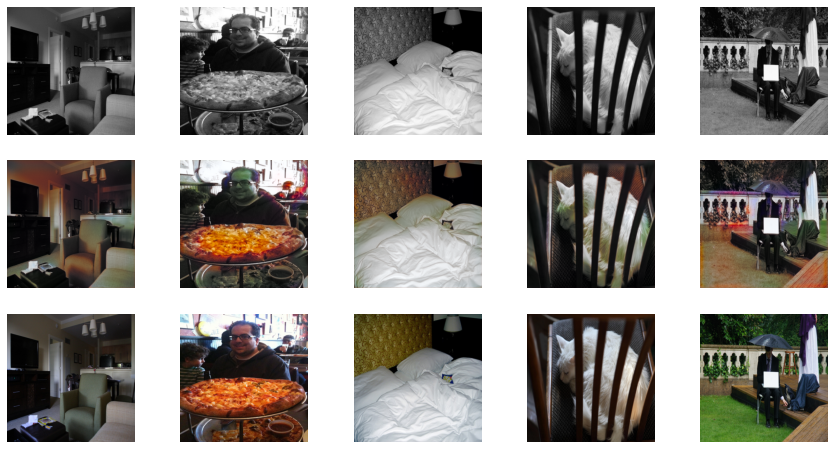

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 4/100
Iteration 200/500
loss_D_fake: 0.52899
loss_D_real: 0.59520
loss_D: 0.56210
loss_G_GAN_PERC: 0.50507
loss_G_GAN_CRIT: 1.26614
loss_G_L1: 11.11104
loss_G: 12.88225


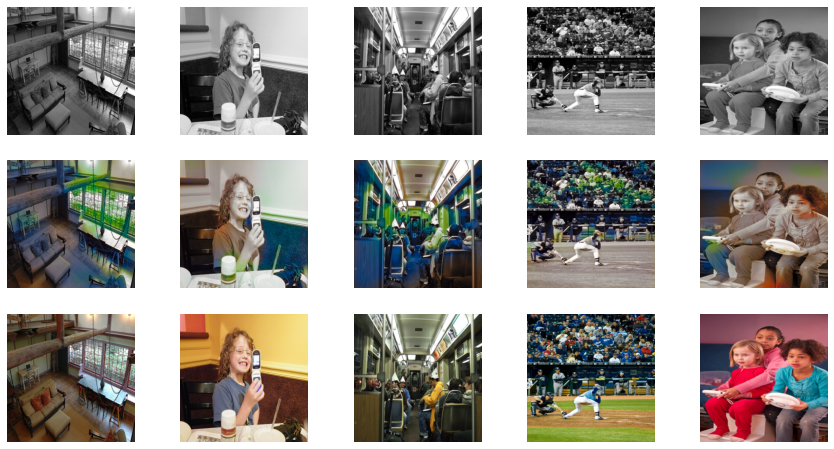


Epoch 4/100
Iteration 400/500
loss_D_fake: 0.53419
loss_D_real: 0.60769
loss_D: 0.57094
loss_G_GAN_PERC: 0.50201
loss_G_GAN_CRIT: 1.23522
loss_G_L1: 11.13650
loss_G: 12.87374


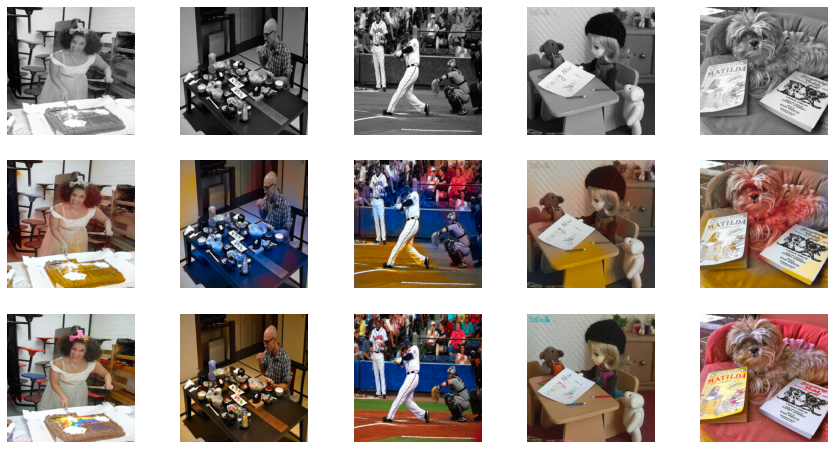

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 5/100
Iteration 200/500
loss_D_fake: 0.54447
loss_D_real: 0.63284
loss_D: 0.58865
loss_G_GAN_PERC: 0.49239
loss_G_GAN_CRIT: 1.15222
loss_G_L1: 10.85964
loss_G: 12.50425


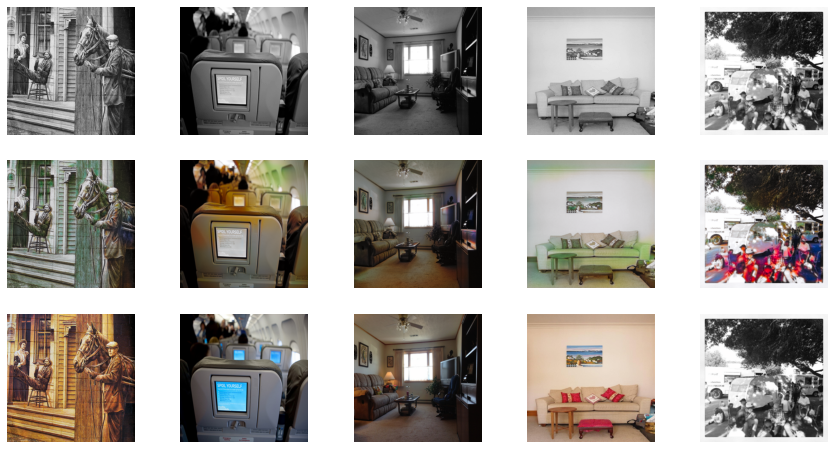


Epoch 5/100
Iteration 400/500
loss_D_fake: 0.53990
loss_D_real: 0.62174
loss_D: 0.58082
loss_G_GAN_PERC: 0.48999
loss_G_GAN_CRIT: 1.15102
loss_G_L1: 10.97744
loss_G: 12.61844


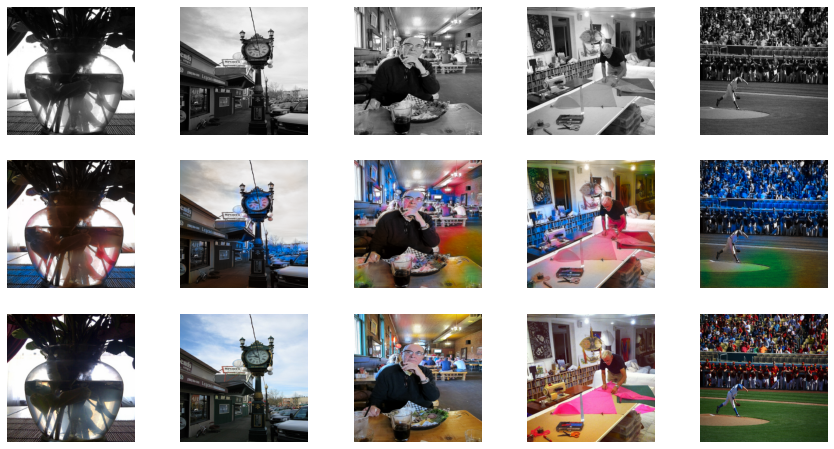

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 6/100
Iteration 200/500
loss_D_fake: 0.54925
loss_D_real: 0.63536
loss_D: 0.59230
loss_G_GAN_PERC: 0.48476
loss_G_GAN_CRIT: 1.11921
loss_G_L1: 10.86423
loss_G: 12.46821


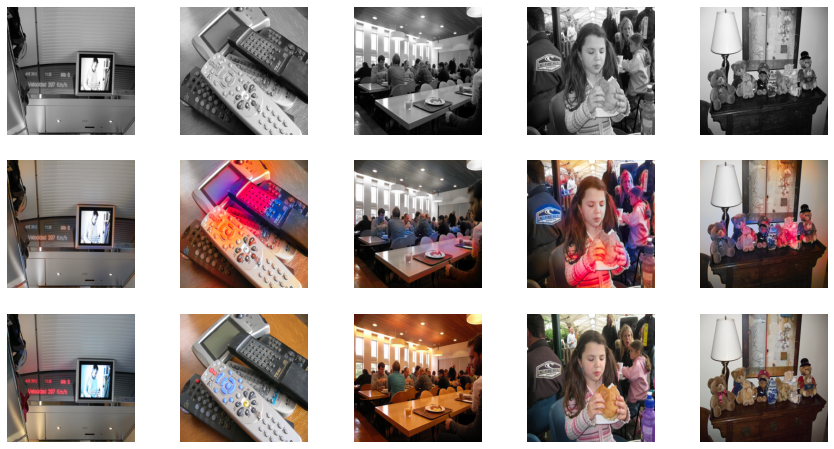


Epoch 6/100
Iteration 400/500
loss_D_fake: 0.54527
loss_D_real: 0.62459
loss_D: 0.58493
loss_G_GAN_PERC: 0.48351
loss_G_GAN_CRIT: 1.12871
loss_G_L1: 10.89155
loss_G: 12.50378


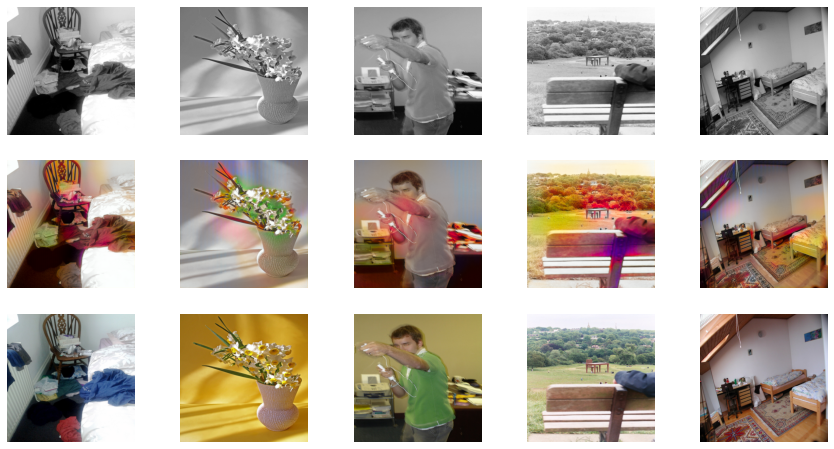

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

path_g = "/content/gdrive/MyDrive/weights/generator.pt"
path_d = "/content/gdrive/MyDrive/weights/discriminator.pt"
path_go = "/content/gdrive/MyDrive/weights/generator_optimizer.pt"
path_do = "/content/gdrive/MyDrive/weights/discriminator_optimizer.pt"

model = MainModel()
train_model(model, train_dataloader, 100, path_g, path_d, path_go, path_do)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()
model = None
gc.collect()
torch.cuda.empty_cache()
with torch.no_grad():
    torch.cuda.empty_cache()
del model

###LOSS

In [ ]:
def transform_img(img):
  transform = transforms.ToPILImage()
  img_show = transform(img.squeeze())
  return img_show

In [ ]:
data = next(iter(train_dataloader))
L_imgs = data['L']
ab_imgs = data['ab']

L_imgs.cuda()
ab_imgs.cuda()
#L_imgs = (L_imgs + 1.) * 50
#ab_imgs = ab_imgs * 110
true_img = torch.cat((L_imgs, ab_imgs), dim=1)

In [ ]:
unet = Unet()
unet_output = unet(L_imgs)
output = torch.cat((L_imgs, unet_output), 1)

patch = PatchDiscriminator()
real_output = patch(true_img)
fake_output = patch(output.detach())


In [ ]:
transform_img(true_img)

In [ ]:
transform_img(output)

In [ ]:
def normalize_tensor_values(input_tensor):
  flattened_output = input_tensor.view(input_tensor.shape[0], -1, 1, 1)
  min, _ = torch.min(flattened_output, dim=1, keepdim=True)
  max, _ = torch.max(flattened_output, dim=1, keepdim=True)
  input_tensor = (input_tensor - min) / (max - min)
  return input_tensor

In [ ]:
normalize_tensor_values(unet_output)
normalize_tensor_values(true_img)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
discr_loss = UNetGANLoss('discriminator', 'vanilla', real_output, fake_output)
dl = discr_loss()
gener_loss = UNetGANLoss('generator', 'perceptual', real_output, fake_output)
gl = gener_loss()